### EEGNet on windowed eeg dataset

This code is designed to train an ANN EEGNet network and convert it to SNN model using Spiking Jelly library. The dataset contains clean eeg data (32 channels x 25 seconds) split in epoch of duration of 5 seconds with an overlap of 4 seconds.

In [ ]:
from google.colab import drive
# mount the Google Drive files to Colab
drive.mount('/content/drive/')

#!ls drive/MyDrive/
import sys
import glob
sys.path.append('/content/drive/MyDrive/Thesis/')

PATH = "/content/drive/MyDrive/Thesis/Model2_EEGNet.pt"
HISTORY_PATH = "/content/drive/MyDrive/Thesis/Model2_EEGNet.pkl"
FILES_PATH = glob.glob("/content/drive/MyDrive/eeg_dataset/filtered_data/*.mat")
LABELS_PATH = "/content/drive/MyDrive/eeg_dataset/scales.xls"
COORD_PATH = "/content/drive/MyDrive/eeg_dataset/Coordinates.xls"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# install required packages - for colab
!pip install autoreject
!pip install mne
!pip install spikingjelly
!pip install snntorch

In [ ]:
# - Basic imports
import torch
import torchvision
import mne
import numpy as np
import os

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [9.6, 3.6]
plt.rcParams['font.size'] = 12

from tqdm.autonotebook import tqdm, trange
# - Import the SNN modules from rockpool

from utils_all_channels import EegData
from bsa import BSA
from poisson import poisson
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd

### Load dataset, split it in the tasks and create epochs

Initial eeg signal has 32 channels X 3200 samples(25 sec of recording with 128 samples per second (SPS)).

Split each signal in epochs of 5 duration sec: 32 channels x 640 samples (5 sec x 128 SPS).
Number of epochs: 40 subjects X 12 trials X 21 epochs = 2400 epochs.

Final dataset: 10080 epochs X 32 channels X 640 samples

In [ ]:
# Read EEG data from the figshare dataset
print((FILES_PATH[0].split('/')))
#SOURCE_DIR = '/content/drive/My Drive/carseg_data/arrays'

arithmetic_task_files = [i for i in FILES_PATH if 'Arithmetic' in i.split('/')[6]]
mirror_image_task_files =[i for i in FILES_PATH if 'Mirror_image' in i.split('/')[6]]
relax_files = [i for i in FILES_PATH if 'Relax' in i.split('/')[6]]
stroop_task_files =  [i for i in FILES_PATH if 'Stroop' in i.split('/')[6]]

print(arithmetic_task_files)
# print(len(arithmetic_task_files), len(mirror_image_task_files), len(relax_files), len(stroop_task_files))
duration = 5
overlap = 4

arithmetic_task_epochs = [EegData.from_mat_file(i, len_segments = duration, overlap=overlap, data_key="Clean_data").data for i in arithmetic_task_files]
mirror_image_task_epochs = [EegData.from_mat_file(i, len_segments = duration, overlap=overlap, data_key="Clean_data").data for i in mirror_image_task_files]
relax_task_epochs = [EegData.from_mat_file(i, len_segments = duration, overlap=overlap, data_key="Clean_data").data for i in relax_files]
stroop_task_epochs = [EegData.from_mat_file(i, len_segments = duration, overlap=overlap, data_key="Clean_data").data for i in stroop_task_files]

data_list = arithmetic_task_epochs + mirror_image_task_epochs + relax_task_epochs + stroop_task_epochs
data_array = np.vstack(data_list)


['', 'content', 'drive', 'MyDrive', 'eeg_dataset', 'filtered_data', 'Arithmetic_sub_10_trial1.mat']
['/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_10_trial1.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_10_trial3.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_10_trial2.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_12_trial2.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_11_trial2.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_11_trial1.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_12_trial1.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_11_trial3.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_13_trial2.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_13_trial1.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_12_trial3.mat', '/conten

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No base

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Ran

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Ran

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Ran

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not set

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No base

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No base

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 proje

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No base

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No base

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not set

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Ran

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matc

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Ran

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using d

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No base

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using d

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 proje

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Ran

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 proje

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matc

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No base

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No base

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using d

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not set

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Ran

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


In [ ]:
print(data_array.shape)
no_repeat = data_array.shape[0]/(12*40)
# no_repeat = (25 - duration) / (duration - overlap) + 1 (if 25 % duration != 0 or overlap != 0)
print(no_repeat)
print(len(data_list))
print(len(arithmetic_task_epochs), len(mirror_image_task_epochs), len(relax_task_epochs), len(stroop_task_epochs))

(10080, 32, 640)
21.0
480
120 120 120 120


##### Load labels and transform them to binary values ( feedback higher than 5: stressed, less than 5: relaxed)


array([[<Axes: title={'center': 'sub_'}>,
        <Axes: title={'center': 'Arithmetic_trial1'}>,
        <Axes: title={'center': 'Mirror_image_trial1'}>],
       [<Axes: title={'center': 'Stroop_trial1'}>,
        <Axes: title={'center': 'Arithmetic_trial2'}>,
        <Axes: title={'center': 'Mirror_image_trial2'}>],
       [<Axes: title={'center': 'Stroop_trial2'}>,
        <Axes: title={'center': 'Arithmetic_trial3'}>,
        <Axes: title={'center': 'Mirror_image_trial3'}>],
       [<Axes: title={'center': 'Stroop_trial3'}>, <Axes: >, <Axes: >]],
      dtype=object)

<Figure size 2880x1080 with 0 Axes>

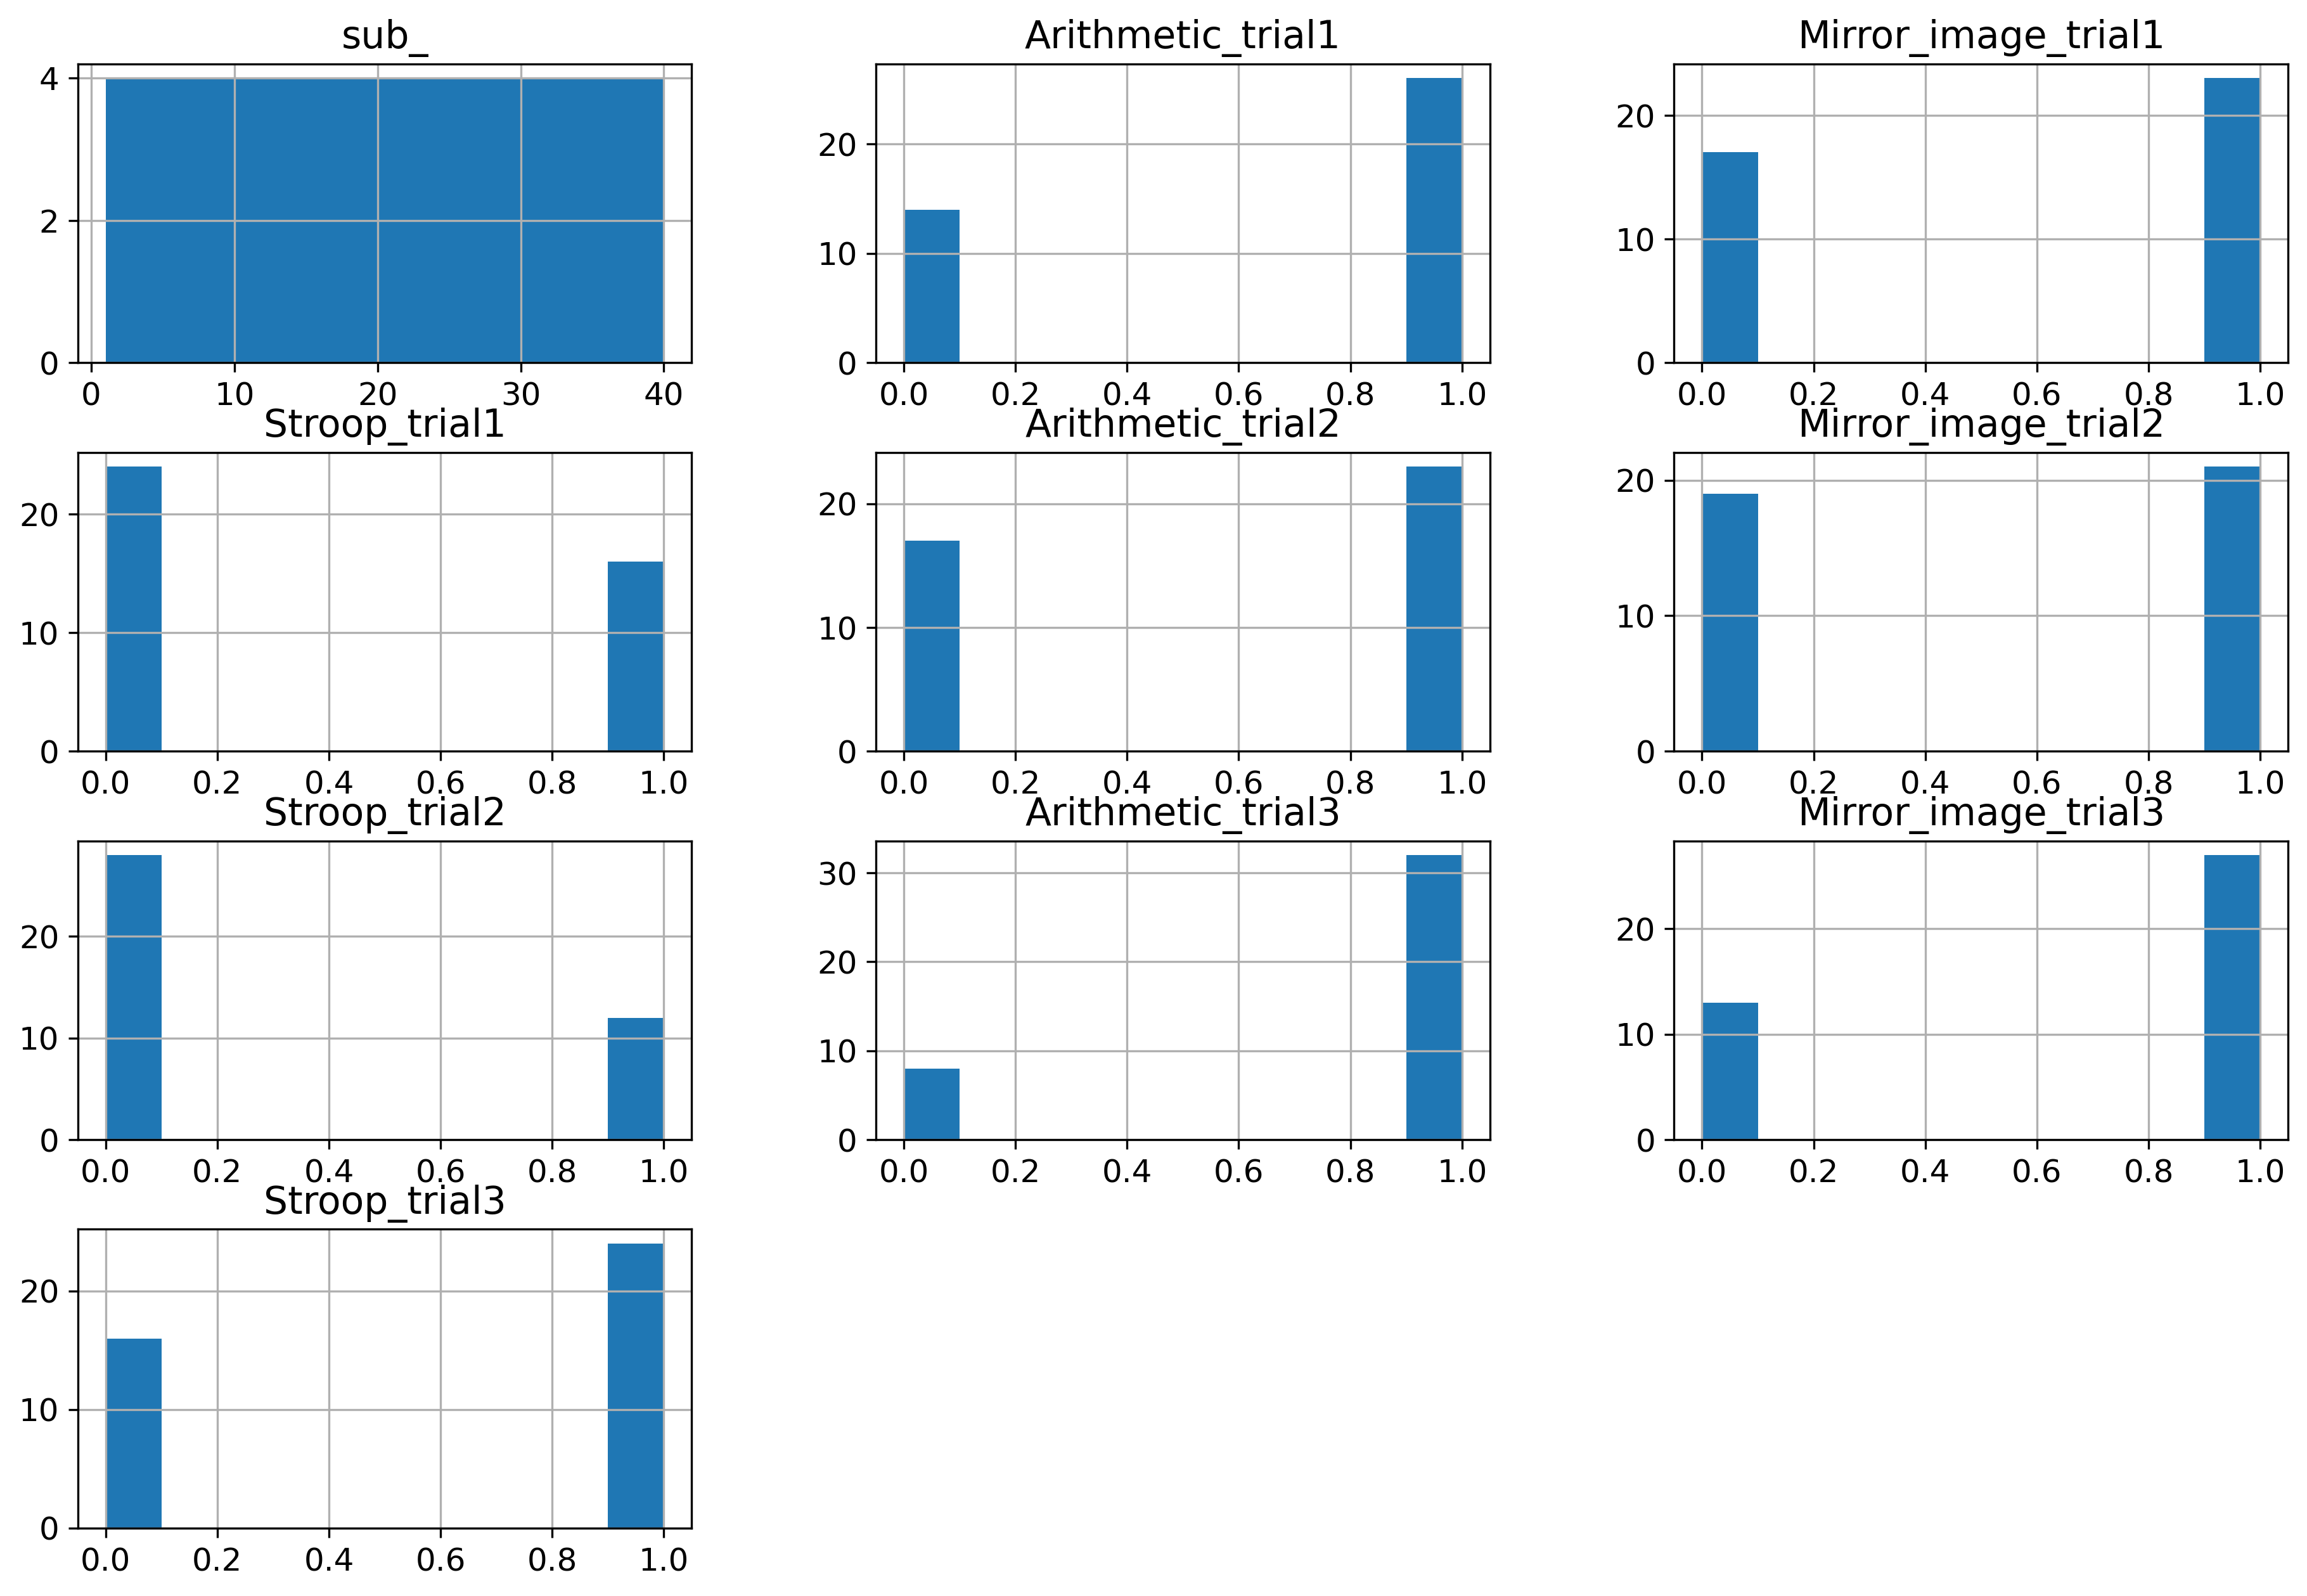

In [ ]:
# create labels: 0 - relaxed, 1 - stressed
COLUMNS_TO_RENAME = {
    'Subject No.': 'sub_',
    'Trial_1': 'Arithmetic_trial1',
    'Unnamed: 2': 'Mirror_image_trial1',
    'Unnamed: 3': 'Stroop_trial1',
    'Trial_2': 'Arithmetic_trial2',
    'Unnamed: 5': 'Mirror_image_trial2',
    'Unnamed: 6': 'Stroop_trial2',
    'Trial_3': 'Arithmetic_trial3',
    'Unnamed: 8': 'Mirror_image_trial3',
    'Unnamed: 9': 'Stroop_trial3'
}

def load_labels():
    '''
    Loads labels from the dataset and transforms the label values to binary values.

    Returns:
        ndarray: The labels.
    '''
    labels = pd.read_excel(LABELS_PATH)
    labels = labels.rename(columns=COLUMNS_TO_RENAME)
    labels = labels[1:]

    labels.iloc[:, 1:] = labels.iloc[:, 1:] >= 5
    labels = labels.astype("int")
    return labels

labels = load_labels()
plt.figure()
labels.hist(figsize=(15,10))
#print(labels)

In [ ]:
# Match data files with the labels values
# file = eeg_dataset/filtered_data\Task_sub_no_trialno.mat
def get_label(path_file):

    # extract only file name from the path_file
    file = os.path.basename(path_file)

    # remove .mat extension
    file = file.split('.')[0]

    # split the file into data frame columns
    split_file = file.split('_')

    # extract line and column from data frame
    line = int(split_file[len(split_file) - 2]) - 1

    # special case for Mirror_image
    if (len(split_file) == 5):
        split_file[0] = split_file[0] + '_' + split_file[1]
    column_name = split_file[0] + "_" + split_file[len(split_file) - 1]

    return labels.iloc[line][str(column_name)]

# extract labels for each task, subject and trial
arithmetic_task_labels = [get_label(i) for i in arithmetic_task_files]
relax_labels = [0 for i in relax_files]
stroop_task_labels =  [get_label(i) for i in stroop_task_files]
mirror_image_task_labels =[get_label(i) for i in mirror_image_task_files]

#repeat the labels for the specified amount of epochs
arithmetic_task_labels = np.array(arithmetic_task_labels).repeat(no_repeat)
relax_labels = np.array(relax_labels).repeat(no_repeat)
stroop_task_labels = np.array(stroop_task_labels).repeat(no_repeat)
mirror_image_task_labels = np.array(mirror_image_task_labels).repeat(no_repeat)

label_array = np.concatenate((arithmetic_task_labels, relax_labels, stroop_task_labels, mirror_image_task_labels))
print(label_array.shape)
#d = {'files': arithmetic_task_files, 'labels': arithmetic_task_labels}
#df = pd.DataFrame(data=d)
#print(df)

(10080,)


##### Split dataset in train set, validation set and testing set

In [ ]:
from torch.utils.data import Dataset, ConcatDataset


class EpochsDataset(Dataset):
    """Class to expose an MNE Epochs object as PyTorch dataset.

    Parameters
    ----------
    epochs_data : np.ndarray
        The epochs data, shape (n_epochs, n_channels, n_times).
    epochs_labels : np.ndarray
        The epochs labels, shape (n_epochs,)
    subj_nb: None | int
        Subject number.
    rec_nb: None | int
        Recording number.
    transform : callable | None
        The function to eventually apply to each epoch
        for preprocessing (e.g. scaling). Defaults to None.
    """
    def __init__(self, epochs_data, epochs_labels, subj_nb=None,
                 rec_nb=None, transform=None):
        assert len(epochs_data) == len(epochs_labels)
        self.epochs_data = epochs_data
        self.epochs_labels = epochs_labels
        self.subj_nb = subj_nb
        self.rec_nb = rec_nb
        self.transform = transform

    def __len__(self):
        return len(self.epochs_labels)

    def __getitem__(self, idx):
        X, y = self.epochs_data[idx], self.epochs_labels[idx]
        if self.transform is not None:
            X = self.transform(X)
            X = torch.as_tensor(X[None, ...])
        return X, y


def scale(X):
    """Standard scaling of data along the last dimention.

    Parameters
    ----------
    X : array, shape (n_channels, n_times)
        The input signals.

    Returns
    -------
    X_t : array, shape (n_channels, n_times)
        The scaled signals.
    """
    X -= np.mean(X, axis=1, keepdims=True)
    return X *1000 / np.std(X, axis=1, keepdims=True)

In [ ]:
from torch.utils.data import DataLoader, ConcatDataset
# - Create a data loader for the training dataset
x, x_test, y, y_test = train_test_split(data_array, label_array, test_size=0.3, shuffle=True, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.20, shuffle=True, random_state=42)

# Create dataloaders
train_batch_size = 16  # Important hyperparameter
valid_batch_size = 16  # Can be made as large as what fits in memory; won't impact performance
num_workers = 0  # Number of processes to use for the data loading process; 0 is the main Python process


num_classes = 2
kernels = 1

input_channels = 32
print('X_train shape:', x_train.shape)

x_train = torch.Tensor(np.expand_dims(x_train, axis=1))
x_val = torch.Tensor(np.expand_dims(x_val, axis=1))
x_test = torch.Tensor(np.expand_dims(x_test, axis=1))

print(x_train.type())
train_set = EpochsDataset(x_train, y_train)
valid_set = EpochsDataset(x_val, y_val)
test_set = EpochsDataset(x_test, y_test)

print('X_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

print('Number of examples in each set:')
print(f'Training: {len(train_set)}')
print(f'Validation: {len(valid_set)}')
print(f'Test: {len(test_set)}')

loader_train = DataLoader(
    train_set, batch_size=train_batch_size, shuffle=True, num_workers=num_workers)
loader_valid = DataLoader(
    valid_set, batch_size=valid_batch_size, shuffle=True, num_workers=num_workers)
loader_test = DataLoader(
    test_set, batch_size=valid_batch_size, shuffle=True, num_workers=num_workers)


X_train shape: (5644, 32, 640)
torch.FloatTensor
X_train shape: torch.Size([5644, 1, 32, 640])
y_train shape: (5644,)
5644 train samples
3024 test samples
Number of examples in each set:
Training: 5644
Validation: 1412
Test: 3024


# Building EEG Net

### Define the model. training it and test it

In [ ]:
def plot_acc_and_loss(history, figsize=(10,4)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    ax1.title.set_text("Acc")
    ax1.set_xlabel("Epochs")
    l1 = ax1.plot(history["acc"], color="red", label='train')
    l2 = ax1.plot(history["val_acc"], color="blue", label='test')

    ax2.title.set_text("Loss")
    ax2.set_ylabel("Epochs")
    l3 = ax2.plot(history["loss"], color="red", label='train')
    l4 = ax2.plot(history["val_loss"], color="blue", label='test')

    ax1.legend(loc="upper right")
    ax2.legend(loc="upper right")

    plt.show()

In [ ]:
# - Determine which advice to use for training
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(device)

cuda


In [ ]:
import torch
import torch.nn as nn
import os, time
import torch.optim as optim
import pickle

class Model(object):
    def __init__(self, model=None, lr=0.001):
        super(Model, self).__init__()
        self.model = model
        self.losses = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=lr)

    def fit(self, trainloader=None, validloader=None, epochs=1, monitor=None, only_print_finish_ep_num=False):
        doValid = False if validloader == None else True
        pre_ck_point = [float("inf"), 0.0, float("inf"), 0.0, 0] # loss, acc, val_loss, val_acc, epoch
        history = {"loss": [], "acc": [], "val_loss": [], "val_acc": []}
        print('epoch \t train_loss \t val_loss \t train_acc \t val_acc')
        print('-------------------------------------------------------------------')
        for ep in range(1, epochs + 1):
            proc_start = time.time() # timer start
            if (not (ep % 10)):
                if not only_print_finish_ep_num:
                    print(f"Epoch {ep}/{epochs}")
                    print(f'{ep} \t {loss:0.4f} \t {val_loss:0.4f}  \t {acc:0.4f} \t {val_acc:0.4f} \t ')
            self.model.train()       # Train mode
            step = 1                 # Restart step
            for x_batch, y_batch in trainloader:
                x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device)

                pred = self.model(x_batch)
               # print("Pred, x_batch and y_batch for loses", pred.shape, x_batch.shape, y_batch.shape)
                loss = self.losses(pred, y_batch)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                if (not (ep % 10)) or (ep == 1):
                    pbar = int(step * 30 / len(trainloader))
                    if not only_print_finish_ep_num:

                        print("\r{}/{} [{}{}]".format(
                            step, len(trainloader), ">" * pbar, " " * (30 - pbar)), end="")
                    step += 1
            loss, acc = self.evaluate(trainloader)   # Loss & Accuracy
            val_loss, val_acc = self.evaluate(validloader) if doValid else (0, 0)   # if have validation dataset, evaluate validation
            history["loss"] = np.append(history["loss"], loss)
            history["acc"] = np.append(history["acc"], acc)
            history["val_loss"] = np.append(history["val_loss"], val_loss)
            history["val_acc"] = np.append(history["val_acc"], val_acc)
            # Update checkpoint
            if self.__updateCheckpoint(monitor, pre_ck_point, [loss, acc, val_loss, val_acc, ep]):
                save_file_name = f"checkpoint_model_ep-{ep}.pt"
                self.save(save_file_name)
                pre_ck_point = [loss, acc, val_loss, val_acc, ep]
                history['lastest_model_path'] = save_file_name

            if only_print_finish_ep_num and (ep % 50 == 0):
                print(f'{ep} \t {loss:0.4f} \t {val_loss:0.4f}  \t {acc:0.4f} \t {val_acc:0.4f} \t ')
        return history

    def evaluate(self, dataloader, testing = None):
        total, acc = 0, 0
        inference_speed = 0
        self.model.eval()           # Eval mode
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device)
            start_time = time.time()
            pred = self.model(x_batch)
            inference_time = time.time()
            inference_speed += (inference_time - start_time)
            loss = self.losses(pred, y_batch).item()
            total += y_batch.shape[0]     # Number of data
            acc += (torch.sum(pred.argmax(dim=1)==y_batch)).item()     # Sum the prediction that's correct
        acc /= total     # Accuracy = correct prediction / number of data
        inference_speed = inference_speed / total
        if not testing == None:
          print("Average inference time for a batch of size 16 is:", inference_speed)
        return (loss, acc)

    def predict(self, dataset):
          dataloader = DataLoader(dataset=dataset, batch_size=1, shuffle=False)
          prediction = []
          truth = []
          self.model.eval()
          for x_batch, y_batch in dataloader:
              x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device)
              pred = self.model(x_batch).cpu()
              prediction = np.append(prediction, pred.argmax(dim=1).numpy())
              truth = np.append(truth, y_batch.cpu().numpy())
          return prediction, truth

    def save(self, filepath):
          torch.save(self.model, filepath)

    def load(cls, filepath):
        return cls(torch.load(filepath))

    def __updateCheckpoint(self, monitor, pre_ck_point, evaluation):
        if type(monitor) is int:
            return True if evaluation[4] % monitor == 0 else False
        elif type(monitor) is list:
            for _ in monitor:
                if not _ in ["loss", "acc", "val_loss", "val_acc"]:
                    raise Exception(f"\"{_}\" is not a valid monitor condition.")
                elif _ == "loss" and pre_ck_point[0] <= evaluation[0]:
                    return False # present epoch loss > history loss
                elif _ == "acc" and pre_ck_point[1] >= evaluation[1]:
                    return False # present epoch acc <= history acc
                elif _ == "val_loss" and pre_ck_point[2] <= evaluation[2]:
                    return False # present epoch val_loss > history val_loss
                elif _ == "val_acc" and pre_ck_point[3] >= evaluation[3]:
                    return False # present epoch val_acc < history val_acc
        return True

In [ ]:
# define the network structure
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 8, 5, 1),
            nn.BatchNorm2d(8, eps=1e-3),

            nn.Conv2d(8, 16, 5, 1),
            nn.BatchNorm2d(16, eps=1e-3),
            nn.ReLU(),
            nn.AvgPool2d(1, 4),
            nn.Dropout(0.5),

            nn.Conv2d(16, 16, 3, 1),
            nn.Conv2d(16, 32, 3, 1),
            nn.BatchNorm2d(32, eps=1e-3),
            nn.ReLU(),
            nn.AvgPool2d(1, 8),
            nn.Dropout(0.6),

            nn.Flatten(),
            nn.Linear(640, 2),
            #nn.ReLU()
        )

    def forward(self,x):
        x = self.network(x)
        return x

In [ ]:
# define hyperparameters
Learning_Rate = 0.005

EPOCHS = 500

# create the model
eegnet = ANN().to(device)

# load the model
#eegnet.load_state_dict(torch.load(PATH))
#print(eegnet)

# or train the model
model = Model(eegnet, lr=Learning_Rate)
history = model.fit(trainloader=loader_train, validloader=loader_valid, epochs=EPOCHS, monitor=["acc", "val_acc"])

# save the model and the history dict
torch.save(model.model.state_dict(), PATH)

with open(HISTORY_PATH, 'wb') as f:
    pickle.dump(history, f)



epoch 	 train_loss 	 val_loss 	 train_acc 	 val_acc
-------------------------------------------------------------------
353/353 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]Epoch 10/500
10 	 0.7271 	 0.7366  	 0.5773 	 0.5793 	 
353/353 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]Epoch 20/500
20 	 0.6148 	 0.6085  	 0.5948 	 0.5836 	 
353/353 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]Epoch 30/500
30 	 0.7061 	 0.6623  	 0.6122 	 0.5857 	 
353/353 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]Epoch 40/500
40 	 0.6129 	 0.5454  	 0.6244 	 0.5949 	 
353/353 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]Epoch 50/500
50 	 0.6512 	 0.6875  	 0.6869 	 0.6367 	 
353/353 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]Epoch 60/500
60 	 0.6063 	 0.5419  	 0.6658 	 0.6289 	 
353/353 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]Epoch 70/500
70 	 0.4890 	 0.5863  	 0.6382 	 0.6020 	 
353/353 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]Epoch 80/500
80 	 0.6982 	 0.4260  	 0.6981 	 0.6438 	 
353/353 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]Epoch 90/500
90 	 0.6304 	 0.4483  	 0.6743 	 0.6289 	 
353/353 [>>>>>>>

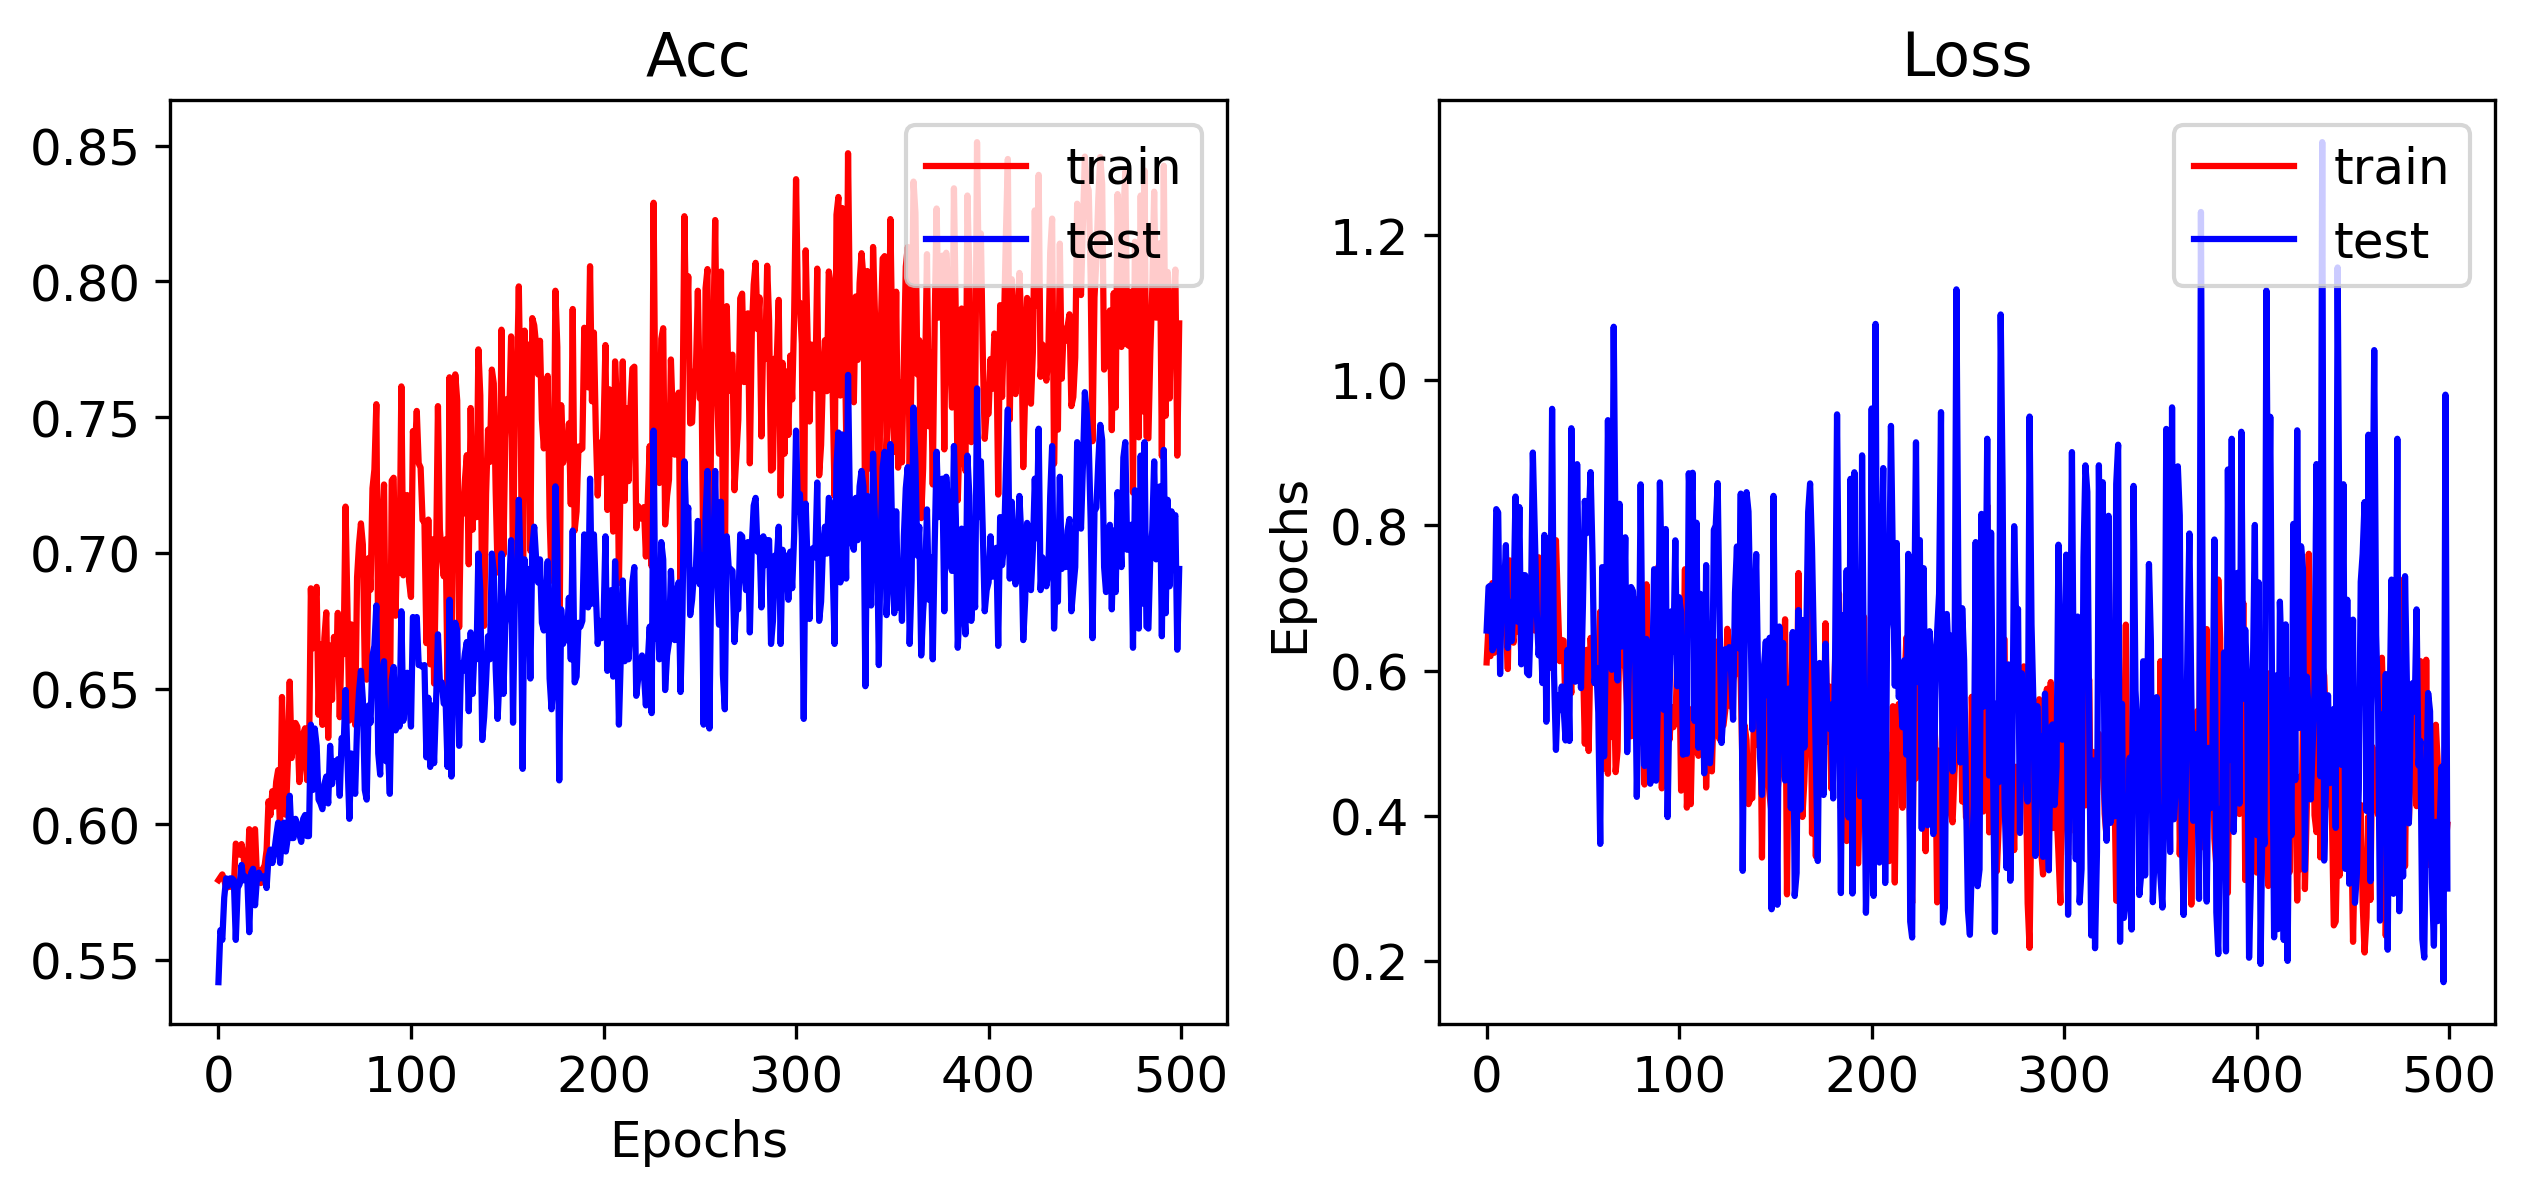

In [ ]:
#plot the accuracy and the loss
plot_acc_and_loss(history=history)

In [ ]:
print(f"Max valid accuracy is:", max(history['val_acc']))
print(f"Avg valid accuracy is:", sum(history['val_acc'])/len(history['val_acc']))

Max valid accuracy is: 0.7655807365439093
Avg valid accuracy is: 0.6746869688385283


In [ ]:
# test the performance of the model
loss, acc = model.evaluate(loader_test)

print(f"Test loss is:", loss)
print(f"Test accuracy is", acc)

Test loss is: 0.6419192552566528
Test accuracy is 0.701058201058201


### Convert ANN to SNN

In [ ]:
def val(net, device, data_loader, T=None):
    net.eval().to(device)
    correct = 0.0
    total = 0.0
    inference_speed = 0
    if T is not None:
        corrects = np.zeros(T)
    with torch.no_grad():
        for batch, (img, label) in enumerate(tqdm(data_loader)):
            img = img.to(device)
            if T is None:
                start_time = time.time()
                out = net(img)
                inference_time = time.time()
                inference_speed += (inference_time - start_time)
                correct += (out.argmax(dim=1) == label.to(device)).float().sum().item()
            else:
                for m in net.modules():
                    if hasattr(m, 'reset'):
                        m.reset()
                for t in range(T):
                    if t == 0:
                        out = net(img)
                    else:
                        out += net(img)
                    corrects[t] += (out.argmax(dim=1) == label.to(device)).float().sum().item()
            total += out.shape[0]
        inference_speed = inference_speed / total
        print(f'Average inference time for a batch of size {train_batch_size} is:', inference_speed)
    return correct / total if T is None else corrects / total

Define the modes as max, 99.9% , 1.0/2 , 1.0/3 , 1.0/4 , 1.0/ 5 case SNN transformation and separate inference T steps to get the accuracy.

In [ ]:
from spikingjelly.activation_based import neuron, encoding, functional, surrogate, layer, ann2snn
T = 50

print("Initial model", model.model)

print('---------------------------------------------')
print('Converting using MaxNorm')
model_converter = ann2snn.Converter(mode='max', dataloader=loader_train)
print(model_converter)

snn_model = model_converter( model.model)

print("SNN converted model", snn_model)
print(snn_model.graph.print_tabular())
print('Simulating...')
mode_max_accs = val(snn_model, device, loader_test, T=T)
print('SNN accuracy (simulation %d time-steps): %.4f' % (T, mode_max_accs[-1]))

print('---------------------------------------------')
print('Converting using RobustNorm')
model_converter = ann2snn.Converter(mode='99.9%', dataloader=loader_train)
snn_model = model_converter( model.model)
print('Simulating...')
mode_robust_accs = val(snn_model, device, loader_test, T=T)
print('SNN accuracy (simulation %d time-steps): %.4f' % (T, mode_robust_accs[-1]))

print('---------------------------------------------')
print('Converting using 1/2 max(activation) as scales...')
model_converter = ann2snn.Converter(mode=1.0 / 2, dataloader=loader_train)
snn_model = model_converter( model.model)
print('Simulating...')
mode_two_accs = val(snn_model, device, loader_test, T=T)
print('SNN accuracy (simulation %d time-steps): %.4f' % (T, mode_two_accs[-1]))

print('---------------------------------------------')
print('Converting using 1/3 max(activation) as scales')
model_converter = ann2snn.Converter(mode=1.0 / 3, dataloader=loader_train)
snn_model = model_converter( model.model)
print('Simulating...')
mode_three_accs = val(snn_model, device, loader_test, T=T)
print('SNN accuracy (simulation %d time-steps): %.4f' % (T, mode_three_accs[-1]))

print('---------------------------------------------')
print('Converting using 1/4 max(activation) as scales')
model_converter = ann2snn.Converter(mode=1.0 / 4, dataloader=loader_train)
snn_model = model_converter( model.model)
print('Simulating...')
mode_four_accs = val(snn_model, device, loader_test, T=T)
print('SNN accuracy (simulation %d time-steps): %.4f' % (T, mode_four_accs[-1]))

print('---------------------------------------------')
print('Converting using 1/5 max(activation) as scales')
model_converter = ann2snn.Converter(mode=1.0 / 5, dataloader=loader_train)
snn_model = model_converter( model.model)
print('Simulating...')
mode_five_accs = val(snn_model, device, loader_test, T=T)
print('SNN accuracy (simulation %d time-steps): %.4f' % (T, mode_five_accs[-1]))

Initial model ANN(
  (network): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): AvgPool2d(kernel_size=1, stride=4, padding=0)
    (6): Dropout(p=0.5, inplace=False)
    (7): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): AvgPool2d(kernel_size=1, stride=8, padding=0)
    (12): Dropout(p=0.6, inplace=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=640, out_features=2, bias=True)
  )
)
---------------------------------------------
Converting using MaxNorm
Converter()


100%|██████████| 353/353 [00:00<00:00, 447.90it/s]


SNN converted model ANN(
  (network): Module(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): AvgPool2d(kernel_size=1, stride=4, padding=0)
    (6): Dropout(p=0.5, inplace=False)
    (7): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (11): AvgPool2d(kernel_size=1, stride=8, padding=0)
    (12): Dropout(p=0.6, inplace=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=640, out_features=2, bias=True)
  )
  (snn tailor): Module(
    (0): Module(
      (0): VoltageScaler(0.059323)
      (1): IFNode(
        v_threshold=1.0, v_reset=None, detach_reset=False, step_mode=s, backend=torch
        (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
      )
      (2): VoltageScaler(16.856861)
    )
    (1): Module(
      (0): VoltageScaler(0.999567)
      (1): IFNode(
        v_threshold=1.0, v_reset=None, detach_reset=False,

  0%|          | 0/189 [00:00<?, ?it/s]

Average inference time for a batch of size 16 is: 0.0
SNN accuracy (simulation 50 time-steps): 0.7196
---------------------------------------------
Converting using RobustNorm


100%|██████████| 353/353 [00:14<00:00, 24.00it/s]

Simulating...


  0%|          | 0/189 [00:00<?, ?it/s]

Average inference time for a batch of size 16 is: 0.0
SNN accuracy (simulation 50 time-steps): 0.6948
---------------------------------------------
Converting using 1/2 max(activation) as scales...


100%|██████████| 353/353 [00:00<00:00, 512.77it/s]

Simulating...


  0%|          | 0/189 [00:00<?, ?it/s]

Average inference time for a batch of size 16 is: 0.0
SNN accuracy (simulation 50 time-steps): 0.7047
---------------------------------------------
Converting using 1/3 max(activation) as scales


100%|██████████| 353/353 [00:00<00:00, 432.70it/s]


Simulating...


  0%|          | 0/189 [00:00<?, ?it/s]

Average inference time for a batch of size 16 is: 0.0
SNN accuracy (simulation 50 time-steps): 0.6941
---------------------------------------------
Converting using 1/4 max(activation) as scales


100%|██████████| 353/353 [00:00<00:00, 518.34it/s]

Simulating...


  0%|          | 0/189 [00:00<?, ?it/s]

Average inference time for a batch of size 16 is: 0.0
SNN accuracy (simulation 50 time-steps): 0.6710
---------------------------------------------
Converting using 1/5 max(activation) as scales


100%|██████████| 353/353 [00:00<00:00, 522.98it/s]

Simulating...


  0%|          | 0/189 [00:00<?, ?it/s]

Average inference time for a batch of size 16 is: 0.0
SNN accuracy (simulation 50 time-steps): 0.6521


Based on the time-varying accuracy of the model output, the accuracy is plotted for different settings.

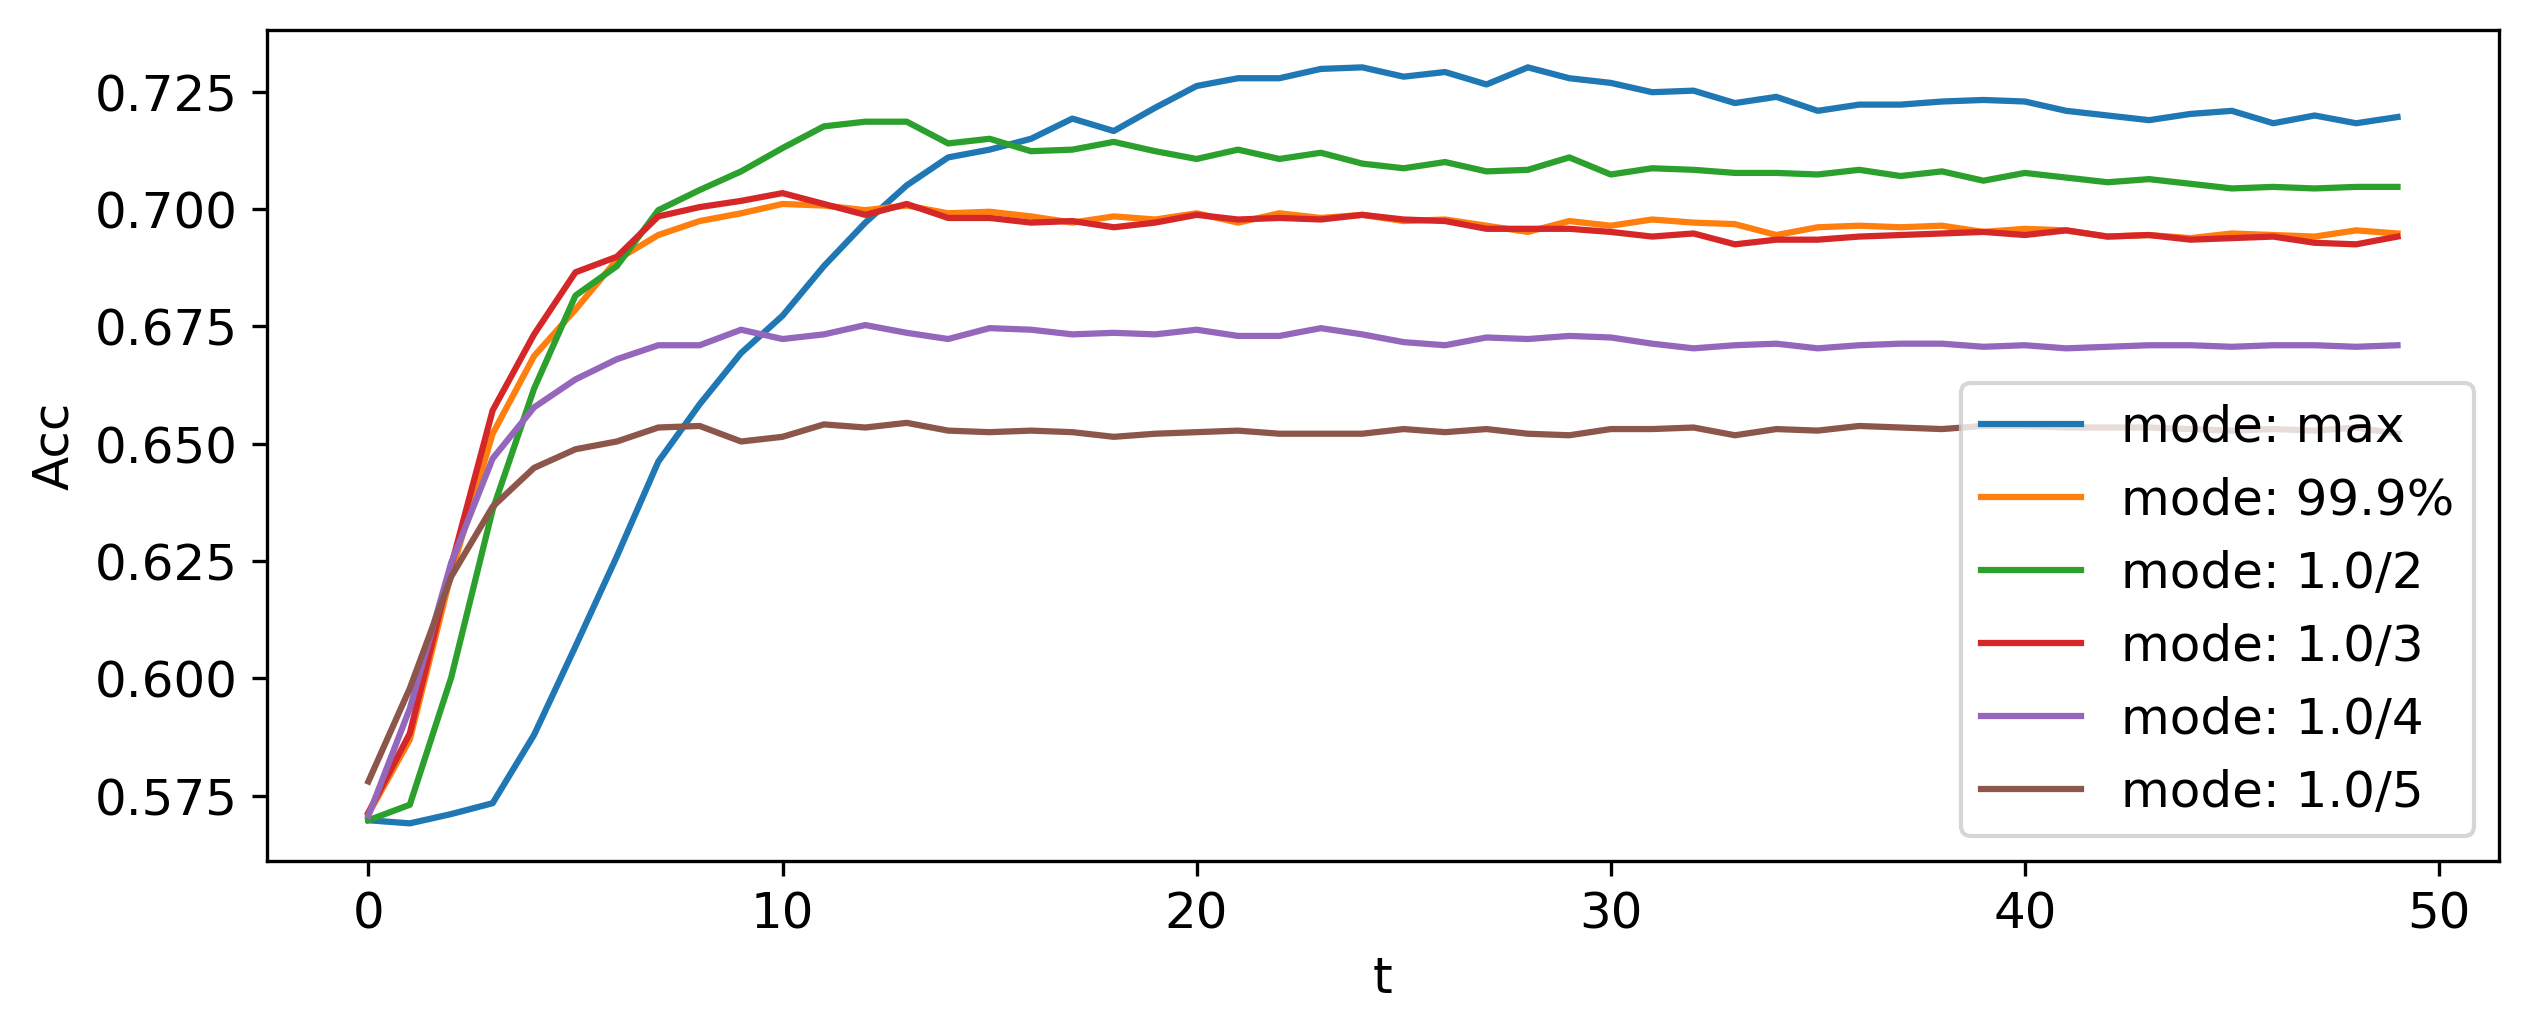

In [ ]:
fig = plt.figure()
plt.plot(np.arange(0, T), mode_max_accs, label='mode: max')
plt.plot(np.arange(0, T), mode_robust_accs, label='mode: 99.9%')
plt.plot(np.arange(0, T), mode_two_accs, label='mode: 1.0/2')
plt.plot(np.arange(0, T), mode_three_accs, label='mode: 1.0/3')
plt.plot(np.arange(0, T), mode_four_accs, label='mode: 1.0/4')
plt.plot(np.arange(0, T), mode_five_accs, label='mode: 1.0/5')
plt.legend()
plt.xlabel('t')
plt.ylabel('Acc')
plt.show()